In [1]:
import numpy as np
from shapely.geometry import box
from shapely import affinity
import matplotlib.pyplot as plt
from descarteslabs.catalog import Product, Image, ImageCollection, properties as p
from descarteslabs.geo import AOI
import cslc_utils as utils

In [2]:
# Get the catalog product for CSLC
prod = Product.get("nasa-opera:sentinel-1:cslc:v1")

In [ ]:
# Central Valley
# aoi_bbox = (-120.1, 35.95, -119.9, 36.05)  # This on an EPSG boundary - slightly different approach needed here
aoi_bbox = (-120.1, 35.75, -119.9, 35.85)
tstart = "2023-12-03"
tend = "2023-12-16"
track = 137

In [3]:
# Hawaii
aoi_bbox = (-155.7374, 19.1231, -155.6593, 19.2141)
tstart = "2023-12-13"
tend = "2023-12-27"
track = 124

In [4]:
# Search for images intersecting area of interest, time period of interest and track of interest
imgs = prod.images().intersects(
    box(*aoi_bbox)
).filter(
    tstart < p.acquired < tend
).filter(
    f"T{track:03d}" < p.provider_id < f"T{track+1:03d}"
).collect()
for ii in imgs:
    print(ii.name, ii.provider_id, ii.cs_code)

OPERA_L2_CSLC-S1_T124-264304-IW2_20231214T043114Z_20231215T080031Z_S1A_VV_v1.0 T124-264304-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264304-IW2_20231214T043114Z_20231215T165006Z_S1A_VV_v1.0 T124-264304-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264304-IW2_20231226T043114Z_20231227T074654Z_S1A_VV_v1.0 T124-264304-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264304-IW2_20231226T043114Z_20231227T075547Z_S1A_VV_v1.0 T124-264304-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264305-IW2_20231214T043117Z_20231215T080031Z_S1A_VV_v1.0 T124-264305-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264305-IW2_20231214T043117Z_20231215T165006Z_S1A_VV_v1.0 T124-264305-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264305-IW2_20231226T043116Z_20231227T074654Z_S1A_VV_v1.0 T124-264305-IW2 EPSG:32605
OPERA_L2_CSLC-S1_T124-264305-IW2_20231226T043116Z_20231227T075547Z_S1A_VV_v1.0 T124-264305-IW2 EPSG:32605


In [5]:
# Deduplicate and organize
stack = utils.group_into_stacks(imgs)
stack

{'T124-264304-IW2': {datetime.date(2023, 12, 14): Image: OPERA_L2_CSLC-S1_T124-264304-IW2_20231214T043114Z_20231215T080031Z_S1A_VV_v1.0
    id: nasa-opera:sentinel-1:cslc:v1:OPERA_L2_CSLC-S1_T124-264304-IW2_20231214T043114Z_20231215T080031Z_S1A_VV_v1.0
    product: nasa-opera:sentinel-1:cslc:v1
    created: Sat Jan  6 00:07:13 2024,
  datetime.date(2023, 12, 26): Image: OPERA_L2_CSLC-S1_T124-264304-IW2_20231226T043114Z_20231227T074654Z_S1A_VV_v1.0
    id: nasa-opera:sentinel-1:cslc:v1:OPERA_L2_CSLC-S1_T124-264304-IW2_20231226T043114Z_20231227T074654Z_S1A_VV_v1.0
    product: nasa-opera:sentinel-1:cslc:v1
    created: Sat Jan  6 00:11:21 2024},
 'T124-264305-IW2': {datetime.date(2023, 12, 14): Image: OPERA_L2_CSLC-S1_T124-264305-IW2_20231214T043117Z_20231215T080031Z_S1A_VV_v1.0
    id: nasa-opera:sentinel-1:cslc:v1:OPERA_L2_CSLC-S1_T124-264305-IW2_20231214T043117Z_20231215T080031Z_S1A_VV_v1.0
    product: nasa-opera:sentinel-1:cslc:v1
    created: Sat Jan  6 00:11:33 2024,
  datetime.da

In [6]:
# Get common area to all 4 bursts here
common_bounds = []
common_epsg = None
coll = ImageCollection()
for pid, bstack in stack.items():
    for k, v in bstack.items():
        if not common_bounds:
            common_bounds = utils.bounds(v)
        else:
            common_bounds = common_bounds.intersection(utils.bounds(v))
            
        if common_epsg is None:
            common_epsg = v.cs_code
            
        if v.cs_code != common_epsg:
            raise RuntimeError(f"Trying to combine bounds from different EPSG codes")
            
        coll.append(v)

common_bounds.bounds, common_epsg

((183570.0, 2112300.0, 283260.0, 2140380.0), 'EPSG:32605')

In [7]:
# Setup common area to pull
# Using 10m here since we are only looking at overlaps
aoi = AOI(
    bounds=affinity.scale(common_bounds, xfact=0.8).bounds,
    bounds_crs=common_epsg,
    resolution=10.0,
    crs=common_epsg,
    align_pixels=True
)
aoi  

AOI(geometry=None,
    resolution=10.0,
    crs='EPSG:32605',
    align_pixels=True,
    bounds=(193539.0, 2112300.0, 273291.0, 2140380.0),
    bounds_crs='EPSG:32605',
    shape=None,
    all_touched=False)

In [8]:
# Pull in the data
arr, info = coll.stack(["real", "imag"], geocontext=aoi, data_type="Float32", raster_info=True)
z = np.zeros((arr.shape[0], arr.shape[2], arr.shape[3]), dtype=np.complex64)
for ii in range(arr.shape[0]):
    z[ii] = (arr[ii, 0] + 1j * arr[ii, 1])
arr = None
z.shape

(4, 2808, 7977)

In [9]:
# Some clean up
z[np.isnan(z)] = 0.
common_mask = np.sum(z == 0, axis=0) == 0
kern = utils.get_kernel(3, 5)

In [10]:
# Top burst interferogram - top in terms of acquisition order
z1 = z[0]
z2 = z[1]
num = utils.smoothed_dot_prod(z1, z2, kern)
dnm = np.sqrt(utils.smoothed_dot_prod(z1, z1, kern, real=True) * utils.smoothed_dot_prod(z2, z2, kern, real=True))
mask = (z1 != 0.) & (z2 != 0.)
dnm[~mask] = 1
num[~mask] = 0
ifg_top = num / dnm
num = None
dnm = None

/tmp/ipykernel_277/2590512082.py:5: RuntimeWarning: invalid value encountered in sqrt
  dnm = np.sqrt(utils.smoothed_dot_prod(z1, z1, kern, real=True) * utils.smoothed_dot_prod(z2, z2, kern, real=True))


In [11]:
# Bottom burst interferogram - bottom in terms of acquisition order
z1 = z[-2]
z2 = z[-1]
num = utils.smoothed_dot_prod(z1, z2, kern)
dnm = np.sqrt(utils.smoothed_dot_prod(z1, z1, kern, real=True) * utils.smoothed_dot_prod(z2, z2, kern, real=True))
mask = (z1 != 0.) & (z2 != 0.)
dnm[~mask] = 1
num[~mask] = 0
ifg_bot = num / dnm
num = None
dnm = None

/tmp/ipykernel_277/2940642800.py:5: RuntimeWarning: invalid value encountered in sqrt
  dnm = np.sqrt(utils.smoothed_dot_prod(z1, z1, kern, real=True) * utils.smoothed_dot_prod(z2, z2, kern, real=True))


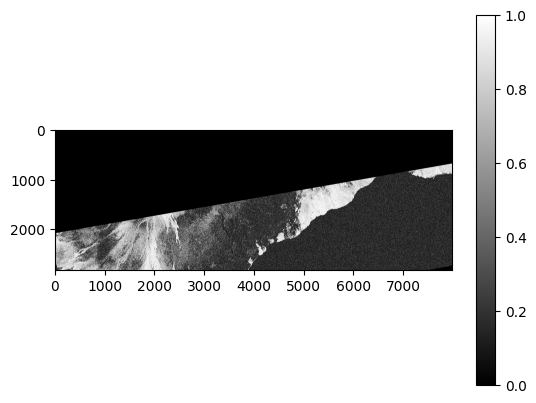

In [12]:
# Top correlation
plt.figure(); plt.imshow(np.abs(ifg_top), vmin=0, vmax=1.0, cmap="gray", interpolation=None); plt.colorbar(); plt.show()

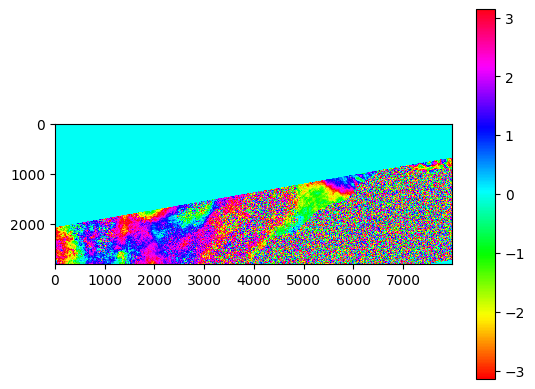

In [13]:
# Top phase
plt.figure(); plt.imshow(np.angle(ifg_top), vmin=-np.pi, vmax=np.pi, cmap="hsv", interpolation="none"); plt.colorbar(); plt.show()

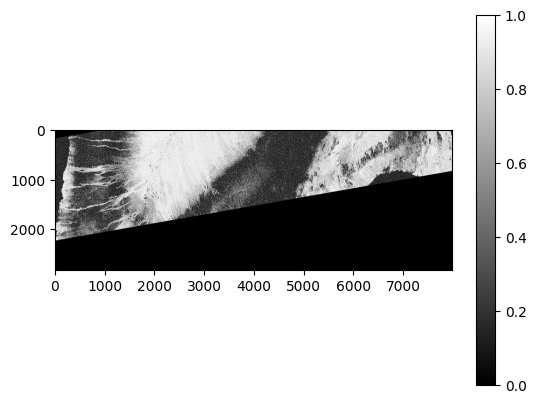

In [14]:
# Bottom correlation
plt.figure(); plt.imshow(np.abs(ifg_bot), vmin=0, vmax=1.0, cmap="gray", interpolation=None); plt.colorbar(); plt.show()

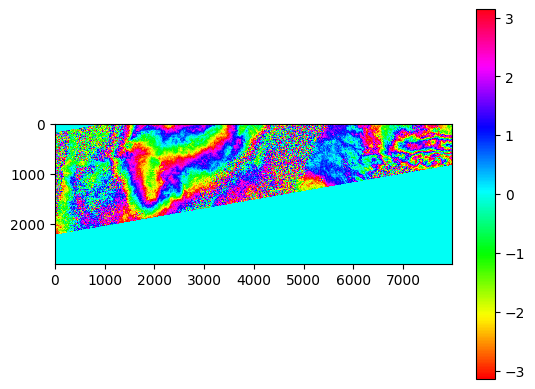

In [15]:
# Bottom phase
plt.figure(); plt.imshow(np.angle(ifg_bot), vmin=-np.pi, vmax=np.pi, cmap="hsv", interpolation="none"); plt.colorbar(); plt.show()

In [16]:
# Using a coherence threshold of 0.85 - same as topsApp.py
cthresh = 0.85
mask = np.logical_and(common_mask, np.logical_and(np.abs(ifg_top) > cthresh, np.abs(ifg_bot) > cthresh))
diff_phase = np.angle(ifg_top[mask] * np.conj(ifg_bot[mask]))

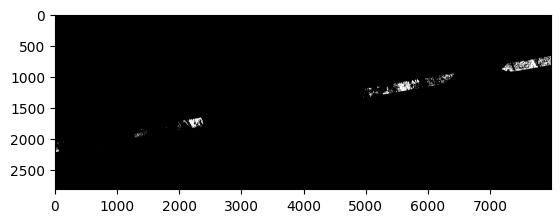

In [17]:
# Show masked area
plt.figure(); plt.imshow(mask, cmap="gray"); plt.show()

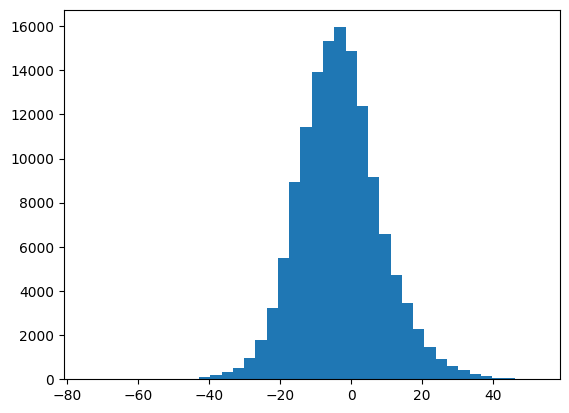

In [18]:
# Plot the phase difference histogram
plt.figure(); plt.hist(np.degrees(diff_phase), bins=40); plt.show()

In [19]:
kern

array([[6.8113579e-05, 2.3839751e-04, 5.6761311e-04, 1.0217036e-03,
        1.4303850e-03, 1.6006690e-03, 1.4303850e-03, 1.0217036e-03,
        5.6761311e-04, 2.3839751e-04, 6.8113579e-05],
       [2.3839751e-04, 8.3439128e-04, 1.9866459e-03, 3.5759627e-03,
        5.0063478e-03, 5.6023416e-03, 5.0063478e-03, 3.5759627e-03,
        1.9866459e-03, 8.3439128e-04, 2.3839751e-04],
       [5.6761311e-04, 1.9866459e-03, 4.7301096e-03, 8.5141966e-03,
        1.1919876e-02, 1.3338909e-02, 1.1919876e-02, 8.5141966e-03,
        4.7301096e-03, 1.9866459e-03, 5.6761311e-04],
       [1.0217036e-03, 3.5759627e-03, 8.5141966e-03, 1.5325555e-02,
        2.1455776e-02, 2.4010036e-02, 2.1455776e-02, 1.5325555e-02,
        8.5141966e-03, 3.5759627e-03, 1.0217036e-03],
       [1.4303850e-03, 5.0063478e-03, 1.1919876e-02, 2.1455776e-02,
        3.0038087e-02, 3.3614051e-02, 3.0038087e-02, 2.1455776e-02,
        1.1919876e-02, 5.0063478e-03, 1.4303850e-03],
       [1.6006690e-03, 5.6023416e-03, 1.3338909e-0